Предобработка данных...
Создание последовательностей...
Разделение данных...

Распределение классов:
1    0.502819
0    0.497181
Name: proportion, dtype: float64

Веса классов: {0: 1, 1: np.float64(0.9887876664330764)}

Создание модели...

Начало обучения...
Epoch 1/20


c:\Users\Slyexistence\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9435 - loss: 0.1704 - precision_1: 0.9408 - recall_1: 0.9427
Epoch 1: val_loss improved from inf to 0.28189, saving model to D:\Проекты\Дипломаня работа\DoFitN\Code\DoFitN\main\model\v2/best_model.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9438 - loss: 0.1697 - precision_1: 0.9412 - recall_1: 0.9430 - val_accuracy: 0.9852 - val_loss: 0.2819 - val_precision_1: 1.0000 - val_recall_1: 0.9704 - learning_rate: 0.0010
Epoch 2/20
84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9862 - loss: 0.0600 - precision_1: 0.9902 - recall_1: 0.9820
Epoch 2: val_loss improved from 0.28189 to 0.10114, saving model to D:\Проекты\Дипломаня работа\DoFitN\Code\DoFitN\main\model\v2/best_model.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9864 - loss: 0.0593 - precision_1: 0.9903 - recall_1: 0.9824 - val_accuracy: 0.9866 - val_loss: 0.1011 - val_precision_1: 0.9792 - val_recall_1: 0.9944 - learning_rate: 0.0010
Epoch 3/20


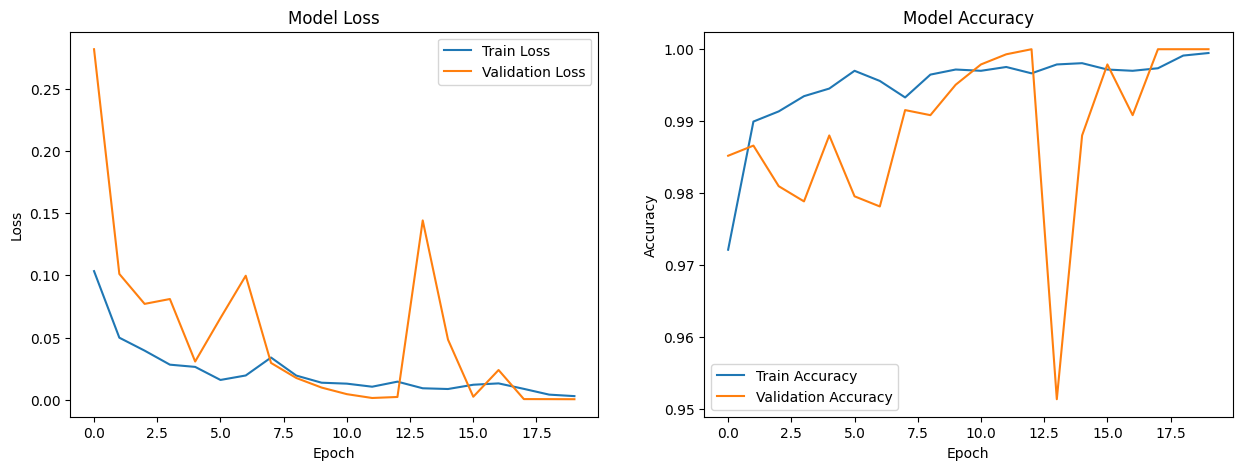


Оценка модели на тестовой выборке:
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       908
           1       1.00      1.00      1.00       866

    accuracy                           1.00      1774
   macro avg       1.00      1.00      1.00      1774
weighted avg       1.00      1.00      1.00      1774



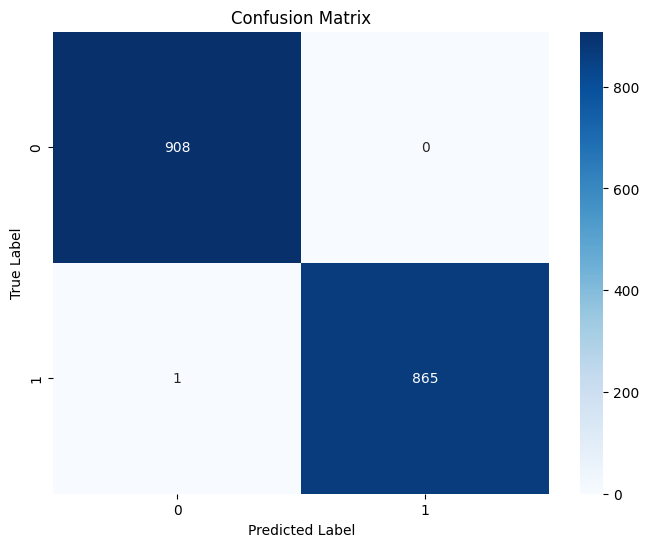


Анализ переобучения:
Минимальная разница потерь: -0.1785
Максимальная разница потерь: 0.0123
Средняя разница потерь: -0.0288
Модель обучена хорошо

Сохранение модели и препроцессоров...
Готово!


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import joblib
# Пути к файлам
data_path = r"D:\Проекты\Дипломаня работа\DoFitN\Code\DoFitN\data\New_data.csv"
model_dir = r"D:\Проекты\Дипломаня работа\DoFitN\Code\DoFitN\main\model\v2"

# Загрузка данных
df = pd.read_csv(data_path)

def preprocess_data(df):
    df_processed = df.copy()
    
    # Нормализация временных меток
    df_processed['time_diff'] = df_processed['timestamp'].diff()
    time_scaler = StandardScaler()
    df_processed['time_diff'] = time_scaler.fit_transform(df_processed['time_diff'].values.reshape(-1, 1))
    
    # Кодирование MAC и IP адресов
    label_encoders = {}
    for feature in ['sender_mac', 'target_mac', 'sender_ip', 'target_ip']:
        label_encoders[feature] = LabelEncoder()
        df_processed[f'{feature}_encoded'] = label_encoders[feature].fit_transform(df_processed[feature])
    
    # Нормализация числовых признаков
    feature_scaler = MinMaxScaler()
    features = [col for col in df_processed.columns if col.endswith('_encoded')] + ['operation', 'time_diff']
    df_processed[features] = feature_scaler.fit_transform(df_processed[features])
    
    return df_processed, label_encoders, {'time': time_scaler, 'features': feature_scaler}

def create_sequences(data, window_size):
    features = [col for col in data.columns if col.endswith('_encoded')] + ['operation', 'time_diff']
    sequences = []
    labels = []
    
    for i in range(len(data) - window_size):
        sequences.append(data[features].iloc[i:i + window_size].values)
        labels.append(data['label'].iloc[i + window_size])
    
    return np.array(sequences), np.array(labels)

def create_model(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True),
        BatchNormalization(),
        Dropout(0.3),
        
        LSTM(32),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(16, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    
    return model

# Параметры
WINDOW_SIZE = 20
BATCH_SIZE = 64
EPOCHS = 20

# Предобработка данных
print("Предобработка данных...")
df_processed, label_encoders, scalers = preprocess_data(df)

# Создание последовательностей
print("Создание последовательностей...")
X, y = create_sequences(df_processed, WINDOW_SIZE)

# Разделение на выборки
print("Разделение данных...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Проверка баланса классов
print("\nРаспределение классов:")
print(pd.Series(y_train).value_counts(normalize=True))

# Настройка весов классов
class_weights = {
    0: 1,
    1: (len(y_train) - sum(y_train)) / sum(y_train)
}
print("\nВеса классов:", class_weights)

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        verbose=1
    ),
    ModelCheckpoint(
        f'{model_dir}/best_model.keras',  # Изменено расширение с .h5 на .keras
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# Создание и обучение модели
print("\nСоздание модели...")
input_shape = (WINDOW_SIZE, X.shape[2])
model = create_model(input_shape)

print("\nНачало обучения...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

# Визуализация обучения
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Оценка модели
print("\nОценка модели на тестовой выборке:")
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary))

# Матрица ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_binary), 
            annot=True, 
            fmt='d',
            cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Проверка на переобучение
def check_overfitting(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    loss_diff = np.array(train_loss) - np.array(val_loss)
    
    print("\nАнализ переобучения:")
    print(f"Минимальная разница потерь: {min(loss_diff):.4f}")
    print(f"Максимальная разница потерь: {max(loss_diff):.4f}")
    print(f"Средняя разница потерь: {np.mean(loss_diff):.4f}")
    
    if np.mean(loss_diff) < -0.1:
        print("Предупреждение: Возможно недообучение (underfitting)")
    elif np.mean(loss_diff) > 0.1:
        print("Предупреждение: Возможно переобучение (overfitting)")
    else:
        print("Модель обучена хорошо")

check_overfitting(history)

# Сохранение модели и препроцессоров
print("\nСохранение модели и препроцессоров...")
model.save(f'{model_dir}/model.keras')  # Изменено расширение с .h5 на .keras
joblib.dump(label_encoders, f'{model_dir}/label_encoders.pkl')
joblib.dump(scalers, f'{model_dir}/scalers.pkl')

print("Готово!")